**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [4]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [5]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [6]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [7]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=60)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

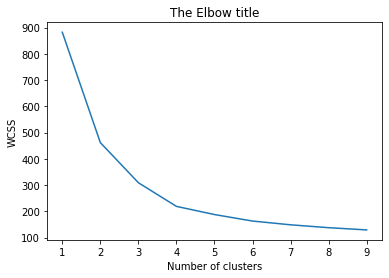

In [8]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [9]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [10]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [11]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [12]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [13]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [14]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [15]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [16]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [17]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [18]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กก', 'สวัสดี', 'น', 'ผม', 'ร้านอาหาร', 'ร้านกาแฟ', 'คน', 'อ', 'นึง', 'บอ', 'จ', 'นขา', 'ๆๆ', 'ขา', 'นะคะ', 'อาหาร', 'ทาน', 'กิน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "กวงทะเลเผา", "อเมซอน", "จาน", "เดลิเวอรี่", "อิ่ม", "เยาวราช", "ไชน่าทาว", "อีกร้าน", "เบเกอรี่", "ชานม", "ชานมไข่มุก", "ชานมไต้หวัน", "ชาไต้หวัน", "ชาไข่มุก", "อีสาน", "สายไหม"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [19]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [20]:
#results of tokenization
from pprint import pprint
pprint(df_kmeans['texts_count'].value_counts())

[(อร่อย, 8), (ซอย, 6), (ส้มตำ, 5), (ราคา, 5), (เพื่อน, 4), (ไทย, 4), (แซ่บ, 4), (รสชาติ, 4), (รีวิว, 3), (ไร้, 3), (าน, 3), (ส, 3), (ยำ, 3), (รา, 3), (เก่าแก่, 3), (รอบ, 3), (ขาย, 3), (เป็ด, 3), (เมนู, 3), (ห, 3), (ดีล, 3), (กาแฟ, 3), (เนื้อ, 2), (ปู, 2), (ถนน, 2), (หัว, 2), (หิน, 2), (สไตล์, 2), (บ้าน, 2), (ข, 2), (แพง, 2), (สา, 2), (อาศัย, 2), (สุขุมวิท, 2), (แคนยอน, 2), (สาขา, 2), (ขับรถ, 2), (เข้ามา, 2), ((, 2), (ญี่ปุ่น, 2), (น้ำ, 2), (หลากหลาย, 2), (เผ็ด, 2), (ท, 2), (ไข่, 2), (รส, 2), (ตั้งอยู่, 2), (ข้าม, 2), (เวลา, 2), (สั่ง, 2), (นึกถึง, 2), (อิ่ม, 2), (พูดถึง, 2), (ร้า, 2), (ชั้น, 2), (เซ็นทรัล, 2), (พระราม, 2), (กวงทะเลเผา, 1), (อาหารทะเล, 1), (เค้า, 1), (สด, 1), (หวาน, 1), (ค, 1), (สมาชิก, 1), (Wongna, 1), (เจ๊, 1), (พิม, 1), (เลี่ยง, 1), (ตลาด, 1), (หนอง, 1), (มน, 1), (ร้, 1), (ตอนเย็น, 1), (รถไฟฟ้า, 1), (ราช, 1), (เทวี, 1), (เดิน, 1), (ย้อแมทช์, 1), (ตกลง, 1), (กล, 1), (คนแนะนำ, 1), (ลอง, 1), (สักหน่อย, 1), (ตกแต่ง, 1), (น่ารัก, 1), (นั่ง, 1), (เรื่อ, 1), (ปั้นหยา, 1), (

In [22]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('อร่อย', 7), ('รีวิว', 6), ('บ้าน', 5), ('ชอบ', 5), ('กาแฟ', 5), ('พาย', 4), ('ซื้อ', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คาเฟ่', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('เลือก', 3), ('ลอง', 3), ('หา', 3), ('ดี', 3), ('สาขา', 3), ('เช้า', 2)]

Cluster ID : 1

Most common words include : [('ชานมไข่มุก', 9), ('เครื่องดื่ม', 4), ('ชาไข่มุก', 4), ('รีวิว', 4), ('ชา', 3), ('ร้า', 3), ('เจอ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('นม', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('ขาย', 2), ('Ochaya', 2)]

Cluster ID : 2

Most common words include : [('อร่อย', 8), ('ซอย', 6), ('ส้มตำ', 5), ('ราคา', 5), ('เพื่อน', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('รีวิว', 3), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('ขาย', 3), ('เป็ด', 3), ('เมนู', 3), ('ห', 3)]

Cluster ID : 3

Most common words include : [('กาแฟ', 19), ('ชอบ', 6), ('น

# **Step 4 - result discussion**

Cluster ID : 0 -> ร้านอาหาร + คาเฟ่

Cluster ID : 1 -> เครื่องดื่ม (ชานมไข่มุก / ชานมไต้หวัน / ชาเขียว)

Cluster ID : 2 -> อาหารคาว (อาหารอีสาน)

Cluster ID : 3 -> คาเฟ่
